In [139]:
# Import the necessary libraries
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

## Dataset Description

**Dataset name and source:**
- Name: solar-power-generation-data
- Source: anikanna from kagglehub



In [140]:
# Download Dataset
# Use kagglehub to download the latest version of the solar power Generation dataset.

# Download latest version
path = kagglehub.dataset_download("anikannal/solar-power-generation-data")

# Print the path to dataset files
print("Path to dataset files:", path)

Path to dataset files: C:\Users\felbe\.cache\kagglehub\datasets\anikannal\solar-power-generation-data\versions\1


In [141]:
# Load the first dataset into a pandas DataFrame
file_path1 = os.path.join(path, "Plant_1_Generation_Data.csv")
generation_data_initial = pd.read_csv(file_path1)
# fix data set effiency calculation for ac power
generation_data_initial['AC_POWER'] = generation_data_initial['AC_POWER'] * 10

# Load the second dataset into a pandas DataFrame
file_path2 = os.path.join(path, "Plant_1_Weather_Sensor_Data.csv")
weather_data_initial = pd.read_csv(file_path2)

# Explore Dataset

# Display the first few rows of the DataFrame
generation_data_initial.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [142]:
weather_data_initial.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [143]:
# Convert DATE_TIME for combining datasets later

# Convert DATE_TIME columns to datetime format
def convert_datetime(df, column, format, dayfirst=False):
    df[column] = pd.to_datetime(df[column], format=format, dayfirst=dayfirst)
    return df

generation_data_datetime = convert_datetime(generation_data_initial.copy(), 'DATE_TIME', '%d-%m-%Y %H:%M', dayfirst=True)
weather_data_datetime = convert_datetime(weather_data_initial.copy(), 'DATE_TIME', '%Y-%m-%d %H:%M:%S')

In [144]:
def get_max_missing_in_col(df):
    max_miss_count = {}
    for column in df.columns:
        miss_count = 0
        max_streak = 0
        for i in range(1, len(df)):  # Start from 1 to access the previous row
            if pd.isnull(df.iloc[i][column]) and pd.isnull(df.iloc[i-1][column]):
                miss_count += 1
                if miss_count > max_streak:
                    max_streak = miss_count
            else:
                miss_count = 0
        max_miss_count[column] = max_streak

    return  max_miss_count  


def merge_dfs(generation_data, weather_data):
    # Convert each unique inverter source_key to a column for DC_POWER, AC_POWER, DAILY_YIELD, and TOTAL_YIELD
    generation_dc_power = pd.pivot_table(generation_data, index='DATE_TIME', columns='SOURCE_KEY', values='DC_POWER').reset_index()
    generation_ac_power = pd.pivot_table(generation_data, index='DATE_TIME', columns='SOURCE_KEY', values='AC_POWER').reset_index()
    generation_daily_yield = pd.pivot_table(generation_data, index='DATE_TIME', columns='SOURCE_KEY', values='DAILY_YIELD').reset_index()
    
    # TOTAL_YIELD was not added because the data isn't correct. It should start from 0 for each inverter but it doesn't.
    # generation_total_yield = pd.pivot_table(generation_data, index='DATE_TIME', columns='SOURCE_KEY', values='TOTAL_YIELD').reset_index()
    
    # Rename columns to add suffixes
    generation_daily_yield.columns = ['DATE_TIME'] + [f"{col}_daily" for col in generation_daily_yield.columns if col != 'DATE_TIME']
    # generation_total_yield.columns = ['DATE_TIME'] + [f"{col}_total" for col in generation_total_yield.columns if col != 'DATE_TIME']
    
    # Merge the datasets sequentially with unique suffixes
    df = pd.merge(generation_dc_power, generation_ac_power, on='DATE_TIME', suffixes=('_dc', '_ac'))
    df = pd.merge(df, generation_daily_yield, on='DATE_TIME')
    # df = pd.merge(df, generation_total_yield, on='DATE_TIME')
    df = pd.merge(df, weather_data, on='DATE_TIME')
    df.drop(columns=['PLANT_ID', 'SOURCE_KEY'], inplace=True)

    # Check for missing data in the pivot tables
    print("Missing data in Generation Data:")
    print(df.isnull().sum())

    return df

# merge and check missing values
df_initial  = merge_dfs(generation_data_datetime, weather_data_datetime)
missing_periods_initial = get_max_missing_in_col(df_initial)

Missing data in Generation Data:
DATE_TIME                 0
1BY6WEcLGh8j5v7_dc        3
1IF53ai7Xc0U56Y_dc       39
3PZuoBAID5Wc2HD_dc       39
7JYdWkrLSPkdwr4_dc       24
                         ..
zBIq5rxdHJRwDNY_daily    38
zVJPv84UY57bAof_daily    33
AMBIENT_TEMPERATURE       0
MODULE_TEMPERATURE        0
IRRADIATION               0
Length: 70, dtype: int64


In [145]:
def plot_missing_data_periods(missing_periods_data, ax, label):
    ax.bar(missing_periods_data.keys(), missing_periods_data.values(), label=label, alpha=0.4)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Missing Periods')
    ax.tick_params(axis='x', rotation=90)
    ax2 = ax.twinx()
    ax2.set_ylabel('Time (hours:minutes)')
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels([f"{int(x * 15 // 60)}:{int(x * 15 % 60):02d}" for x in ax.get_yticks()])

def get_missing_in_col(df):
    miss_count = {}
    for column in df.columns:
        miss_count[column] = df[column].isnull().sum()
    return miss_count

def plot_missing_data(missing_values_data, ax, label):
    ax.bar(missing_values_data.keys(), missing_values_data.values(), label=label, alpha=0.4)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Missing Values')
    ax.tick_params(axis='x', rotation=90)

missing_values_initial = get_missing_in_col(df_initial)

In [146]:

def remove_duplicates(df):
    # Check for duplicate rows
    print("Number of duplicates in Generation data:")
    print(df.duplicated().sum())
    
    # Drop duplicates
    df.drop_duplicates(inplace=True)
    
    return df
# Remove duplicates
df_initial = remove_duplicates(df_initial)

Number of duplicates in Generation data:
0


In [147]:
# Find outliers in the data and delete them
# Check for outliers in the generation data
generation_data_datetime.describe()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,2020-06-01 08:02:49.458256896,4135001.0,3147.426211,3078.027523,3295.968737,6.978712e+06
min,2020-05-15 00:00:00,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,2020-05-24 00:45:00,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,2020-06-01 14:30:00,4135001.0,429.000000,414.937500,2658.714286,7.146685e+06
75%,2020-06-09 20:00:00,4135001.0,6366.964286,6236.187500,6274.000000,7.268706e+06
max,2020-06-17 23:45:00,4135001.0,14471.125000,14109.500000,9163.000000,7.846821e+06
std,NaN,0.0,4036.457169,3943.964387,3145.178309,4.162720e+05


In [148]:
# Remove outliers from the generation data
def remove_outliers(data, columns, lower_quantile=None, upper_quantile=None):
    # Create a copy of the data to avoid modifying the original DataFrame
    data_copy = data.copy()
    
    # Store the number of data points before removing outliers
    datapoints_before = data_copy.shape[0]
    
    # Dictionaries to store the upper and lower percentiles for each column
    upper_percent = {}
    lower_percent = {}
    
    # Calculate the upper and lower percentiles for each specified column
    for column in columns:
        if upper_quantile is not None:
            upper_percent[column] = data_copy[column].quantile(upper_quantile)
            
        if lower_quantile is not None:
            lower_percent[column] = data_copy[column].quantile(lower_quantile)
    
    # Replace outliers with None (NaN) for each specified column
    for column in columns:
        if upper_quantile is not None:
            data_copy.loc[data_copy[column] > upper_percent[column], column] = None
            
        if lower_quantile is not None:
            data_copy.loc[data_copy[column] < lower_percent[column], column] = None
    
    # Store the number of data points after removing outliers
    datapoints_after = data_copy.shape[0]

    # Calculate the number of data points replaced with missing data
    datapoints_replaced = data_copy.isnull().sum().sum() - (datapoints_before - datapoints_after)
    print(f"Number of datapoints replaced with missing data: {datapoints_replaced}")
    
    return data_copy

# Specify the columns to remove outliers from
columns_to_edit = ['DC_POWER', 'AC_POWER']

# Remove outliers from the generation data with specified upper quantile
generation_data_no_outlier = remove_outliers(generation_data_datetime, columns_to_edit, upper_quantile=0.98)

Number of datapoints replaced with missing data: 2752


In [149]:
# Compare the data after removing outliers
generation_data_no_outlier.describe()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778,68778.0,67402.000000,67402.000000,68778.000000,6.877800e+04
mean,2020-06-01 08:02:49.458256896,4135001.0,2946.840933,2882.616227,3295.968737,6.978712e+06
min,2020-05-15 00:00:00,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,2020-05-24 00:45:00,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,2020-06-01 14:30:00,4135001.0,312.642857,301.928571,2658.714286,7.146685e+06
75%,2020-06-09 20:00:00,4135001.0,6034.875000,5912.785714,6274.000000,7.268706e+06
max,2020-06-17 23:45:00,4135001.0,12455.000000,12145.000000,9163.000000,7.846821e+06
std,NaN,0.0,3822.482526,3736.408799,3145.178309,4.162720e+05


In [150]:
# Check for outliers in the weather data
weather_data_datetime.describe()

,DATE_TIME,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3182,3182.0,3182.000000,3182.000000,3182.000000
mean,2020-06-01 05:52:22.080452608,4135001.0,25.531606,31.091015,0.228313
min,2020-05-15 00:00:00,4135001.0,20.398505,18.140415,0.000000
25%,2020-05-23 22:48:45,4135001.0,22.705182,21.090553,0.000000
50%,2020-06-01 09:52:30,4135001.0,24.613814,24.618060,0.024653
75%,2020-06-09 16:56:15,4135001.0,27.920532,41.307840,0.449588
max,2020-06-17 23:45:00,4135001.0,35.252486,65.545714,1.221652
std,NaN,0.0,3.354856,12.261222,0.300836


In [151]:
# Remove outliers from the weather data
weather_data_no_outlier = remove_outliers(weather_data_datetime, ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'], lower_quantile=0.01 , upper_quantile=0.99)

Number of datapoints replaced with missing data: 160


In [152]:
# Compare the data after removing outliers
weather_data_no_outlier.describe()

,DATE_TIME,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3182,3182.0,3118.000000,3118.000000,3150.000000
mean,2020-06-01 05:52:22.080452608,4135001.0,25.489630,30.902506,0.219991
min,2020-05-15 00:00:00,4135001.0,21.082100,19.168304,0.000000
25%,2020-05-23 22:48:45,4135001.0,22.746983,21.126190,0.000000
50%,2020-06-01 09:52:30,4135001.0,24.613814,24.618060,0.021441
75%,2020-06-09 16:56:15,4135001.0,27.866020,40.873828,0.434839
max,2020-06-17 23:45:00,4135001.0,33.757623,60.258821,0.998992
std,NaN,0.0,3.236290,11.924644,0.290708


In [153]:
df_no_outliers  = merge_dfs(generation_data_no_outlier, weather_data_no_outlier)
missing_periods_no_outliers = get_max_missing_in_col(df_no_outliers)

Missing data in Generation Data:
DATE_TIME                  0
1BY6WEcLGh8j5v7_dc        19
1IF53ai7Xc0U56Y_dc       120
3PZuoBAID5Wc2HD_dc       120
7JYdWkrLSPkdwr4_dc        82
                        ... 
zBIq5rxdHJRwDNY_daily     38
zVJPv84UY57bAof_daily     33
AMBIENT_TEMPERATURE       57
MODULE_TEMPERATURE        63
IRRADIATION               28
Length: 70, dtype: int64


In [154]:

missing_values_no_outliers = get_missing_in_col(df_no_outliers)

In [155]:
# Remove duplicates
df_no_outliers = remove_duplicates(df_no_outliers)

Number of duplicates in Generation data:
0


In [156]:
def find_consecutive_missing(df, threshold):
    # copy the DataFrame to avoid modifying the original DataFrame
    df_copy = df.copy()
    # Find indices of rows with consecutive missing values exceeding the threshold
    indices = []
    for column in df_copy.columns:
        miss_count = 0
        for i in range(1, len(df_copy)):  # Start from 1 to access the previous row
            if pd.isnull(df_copy.iloc[i][column]) and pd.isnull(df_copy.iloc[i-1][column]):
                miss_count += 1
                if miss_count > threshold:
                    indices.append(i)
            else:
                miss_count = 0
    return sorted(list(set(indices))) # Remove duplicates and sort the list

# Find rows to delete and max missing count for each column
rows_to_delete = find_consecutive_missing(df_no_outliers, threshold=6)

def delete_rows(df, rows_to_delete):
    # Copy the DataFrame to avoid modifying the original DataFrame
    df_copy = df.copy()
    # Create a new column to with indices 
    df_copy['index'] = df_copy.index
    # Delete rows with consecutive missing values exceeding the threshold
    df_copy.drop(rows_to_delete, inplace=True)
    print(f"Number of rows to deleted: {len(rows_to_delete)}")
    print(f"Rows to deleted: {rows_to_delete}")
    return df_copy



# Delete rows with consecutive missing values exceeding the threshold
df_shortened_missing_period = delete_rows(df_no_outliers, rows_to_delete) 


Number of rows to deleted: 19
Rows to deleted: [15, 16, 67, 83, 84, 243, 244, 245, 443, 444, 445, 446, 447, 448, 449, 591, 938, 2027, 2028]


In [157]:
# Find rows to delete and max missing count for each column
missing_periods_shortened = get_max_missing_in_col(df_shortened_missing_period)
print(f"Max missing count for each column: {missing_periods_shortened}")

Max missing count for each column: {'DATE_TIME': 0, '1BY6WEcLGh8j5v7_dc': 1, '1IF53ai7Xc0U56Y_dc': 6, '3PZuoBAID5Wc2HD_dc': 6, '7JYdWkrLSPkdwr4_dc': 6, 'McdE0feGgRqW7Ca_dc': 6, 'VHMLBKoKgIrUVDU_dc': 6, 'WRmjgnKYAwPKWDb_dc': 6, 'YxYtjZvoooNbGkE_dc': 6, 'ZnxXDlPa8U1GXgE_dc': 6, 'ZoEaEvLYb1n2sOq_dc': 6, 'adLQvlD726eNBSB_dc': 6, 'bvBOhCH3iADSZry_dc': 1, 'iCRJl6heRkivqQ3_dc': 6, 'ih0vzX44oOqAx2f_dc': 6, 'pkci93gMrogZuBj_dc': 6, 'rGa61gmuvPhdLxV_dc': 6, 'sjndEbLyjtCKgGv_dc': 6, 'uHbuxQJl8lW7ozc_dc': 6, 'wCURE6d3bPkepu2_dc': 6, 'z9Y9gH1T5YWrNuG_dc': 6, 'zBIq5rxdHJRwDNY_dc': 6, 'zVJPv84UY57bAof_dc': 6, '1BY6WEcLGh8j5v7_ac': 1, '1IF53ai7Xc0U56Y_ac': 6, '3PZuoBAID5Wc2HD_ac': 6, '7JYdWkrLSPkdwr4_ac': 6, 'McdE0feGgRqW7Ca_ac': 6, 'VHMLBKoKgIrUVDU_ac': 6, 'WRmjgnKYAwPKWDb_ac': 6, 'YxYtjZvoooNbGkE_ac': 6, 'ZnxXDlPa8U1GXgE_ac': 6, 'ZoEaEvLYb1n2sOq_ac': 6, 'adLQvlD726eNBSB_ac': 6, 'bvBOhCH3iADSZry_ac': 1, 'iCRJl6heRkivqQ3_ac': 6, 'ih0vzX44oOqAx2f_ac': 6, 'pkci93gMrogZuBj_ac': 6, 'rGa61gmuvPhdLxV_ac': 6

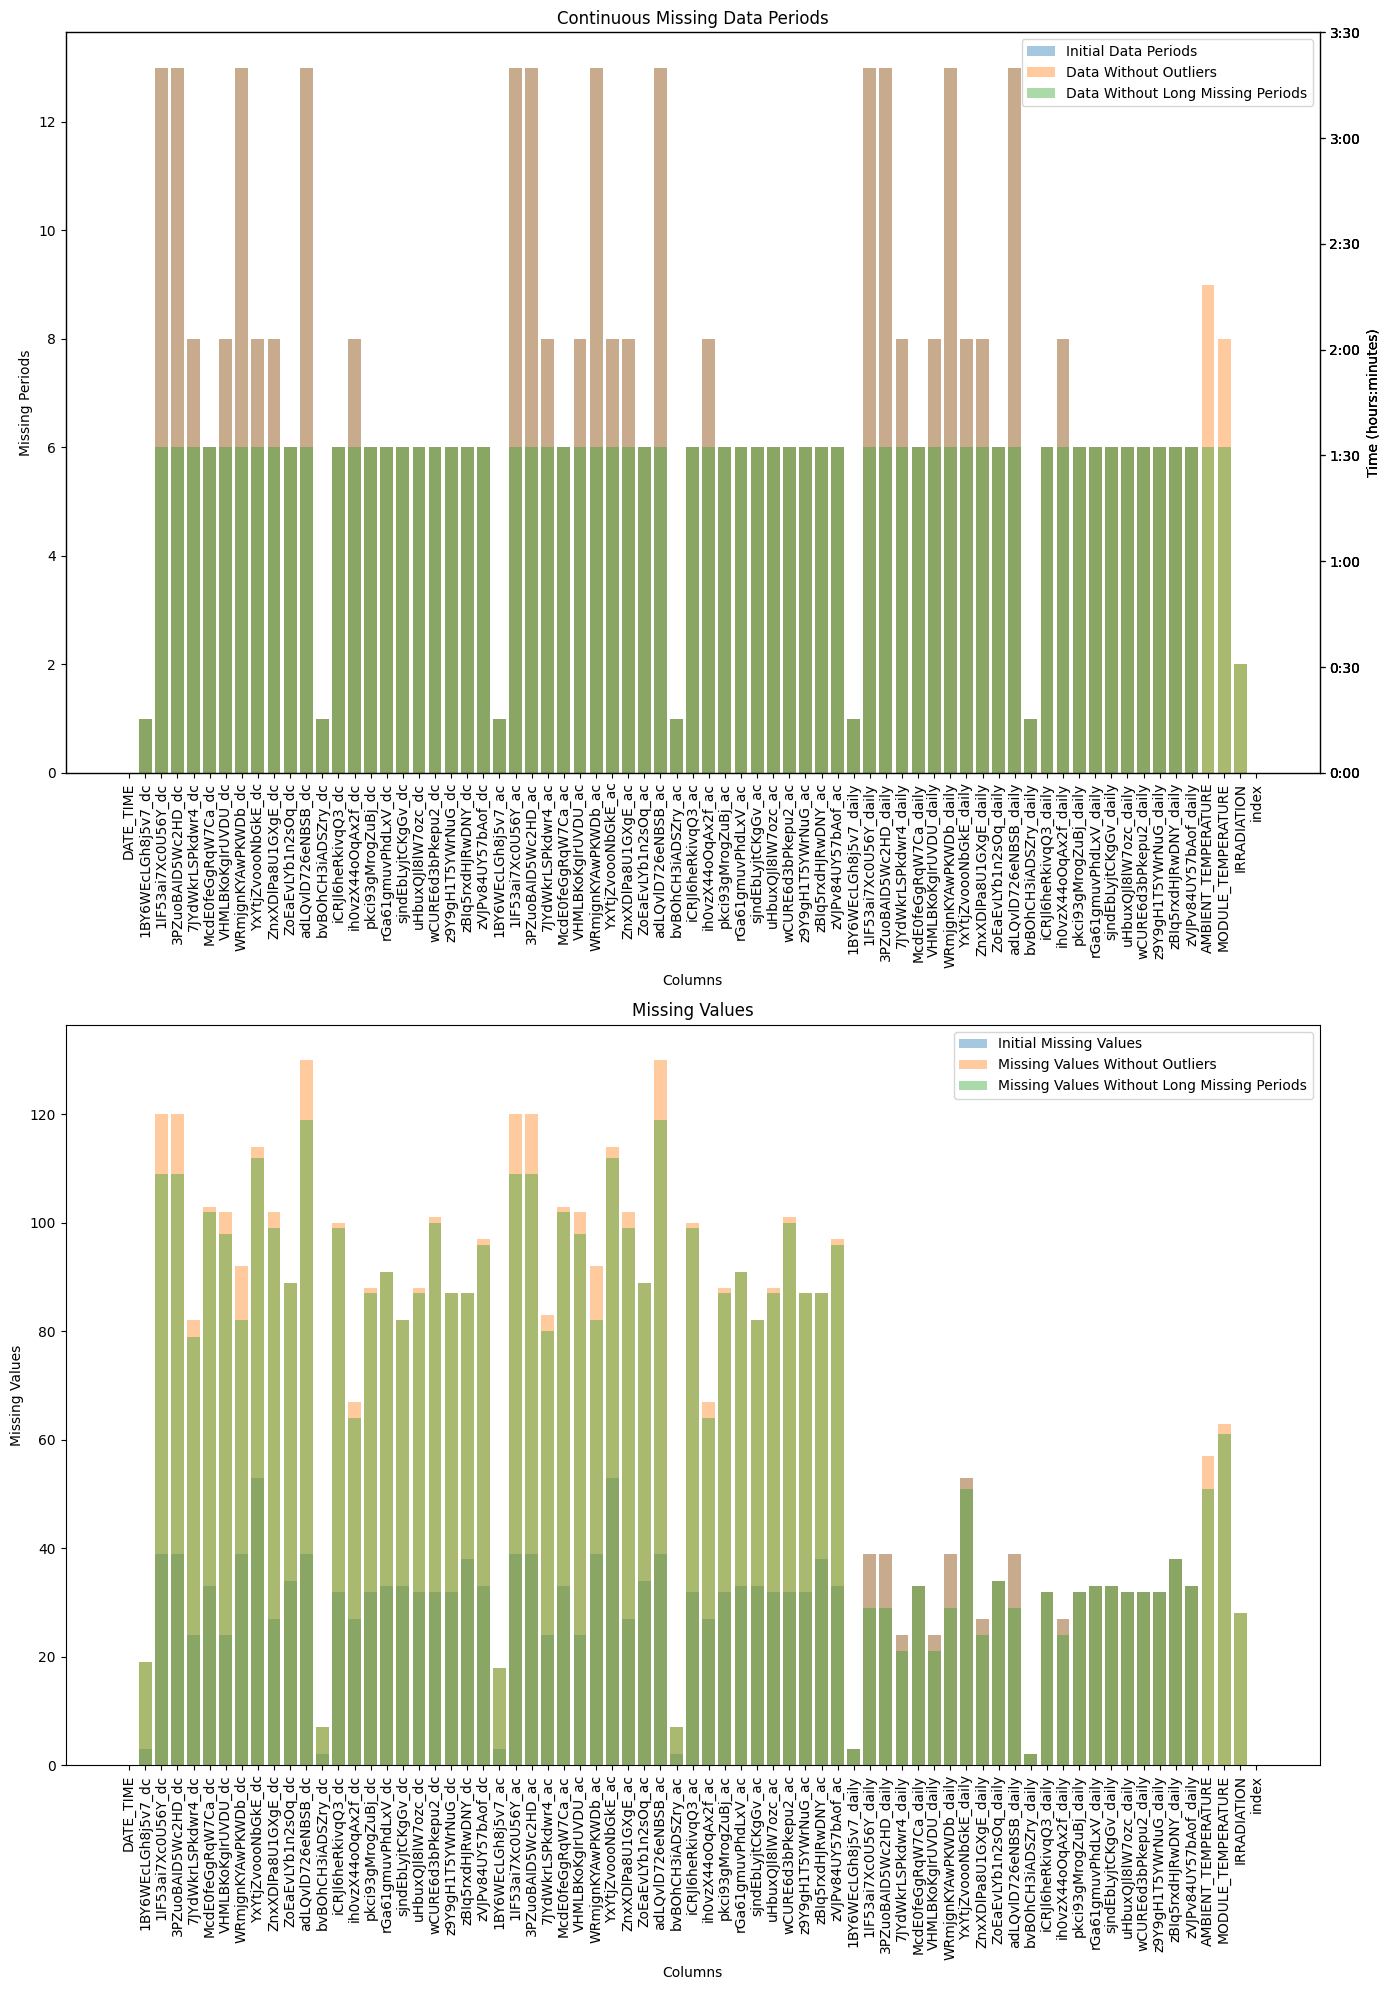

In [158]:
missing_values_shortened = get_missing_in_col(df_shortened_missing_period)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 20))

# Plot the initial missing data periods on the first subplot
plot_missing_data_periods(missing_periods_initial, ax1, label='Initial Data Periods')
plot_missing_data_periods(missing_periods_no_outliers, ax1, label='Data Without Outliers')
plot_missing_data_periods(missing_periods_shortened, ax1, label='Data Without Long Missing Periods')
ax1.set_title('Continuous Missing Data Periods')
ax1.legend()

# Plot the missing values on the second subplot
plot_missing_data(missing_values_initial, ax2, label='Initial Missing Values')
plot_missing_data(missing_values_no_outliers, ax2, label='Missing Values Without Outliers')
plot_missing_data(missing_values_shortened, ax2, label='Missing Values Without Long Missing Periods')
ax2.set_title('Missing Values')
ax2.legend()

plt.tight_layout()
plt.show()

In [159]:
# Interpolate missing values
def interpolate_missing_values(df):
    df_copy = df.copy()
    for column in df_copy.columns:
        if df_copy[column].isnull().any():
            df_copy[column] = df_copy[column].interpolate(method='linear', limit_direction='both')
    return df_copy

# Interpolate missing values
df_interpolated = interpolate_missing_values(df_shortened_missing_period)

In [160]:
# Check for missing values
print("Missing values after interpolation:")
print(df_interpolated.isnull().sum())

Missing values after interpolation:
DATE_TIME                0
1BY6WEcLGh8j5v7_dc       0
1IF53ai7Xc0U56Y_dc       0
3PZuoBAID5Wc2HD_dc       0
7JYdWkrLSPkdwr4_dc       0
                        ..
zVJPv84UY57bAof_daily    0
AMBIENT_TEMPERATURE      0
MODULE_TEMPERATURE       0
IRRADIATION              0
index                    0
Length: 71, dtype: int64


In [161]:
# create a function that takes the dataframe and adds all the values for the inverters and creates a new dataframe with the total values
def sum_inverters(df):
    df_copy = df.copy()
    df_copy['Total_DC'] = df_copy.filter(like='_dc').sum(axis=1)
    df_copy['Total_AC'] = df_copy.filter(like='_ac').sum(axis=1)
    df_copy['Total_Daily'] = df_copy.filter(like='_daily').sum(axis=1)
    # Ensure the required columns are present
    required_columns = ['DATE_TIME', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'Total_DC', 'Total_AC', 'Total_Daily']
    for col in required_columns:
        if col not in df_copy.columns:
            df_copy[col] = None
    # Keep only the required columns
    df_copy = df_copy[required_columns]
    return df_copy


# Sum the values for the inverters
df_summed = sum_inverters(df_interpolated)

# Calculate the total yield 

df_summed['Total_Yield'] = df_summed['Total_DC'].cumsum()


# Check the new dataframe
print(df_summed.head())

            DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
0 2020-05-15 00:00:00            25.184316           22.857507          0.0   
1 2020-05-15 00:15:00            25.084589           22.761668          0.0   
2 2020-05-15 00:30:00            24.935753           22.592306          0.0   
3 2020-05-15 00:45:00            24.846130           22.360852          0.0   
4 2020-05-15 01:00:00            24.621525           22.165423          0.0   

   Total_DC  Total_AC  Total_Daily  Total_Yield  
0       0.0       0.0          0.0          0.0  
1       0.0       0.0          0.0          0.0  
2       0.0       0.0          0.0          0.0  
3       0.0       0.0          0.0          0.0  
4       0.0       0.0          0.0          0.0  


In [162]:
# Confirm the data is clean by checking for duplicates and missing values


# number of duplicates
print("Number of duplicates in summed data:")
print(df_summed.duplicated().sum())

# missing values
print("Missing values in summed data:")
print(df_summed.isnull().sum())

# Save the cleaned data to a new CSV file
df_summed.to_csv('cleaned_solar_power_data.csv', index=False)

Number of duplicates in summed data:
0
Missing values in summed data:
DATE_TIME              0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
Total_DC               0
Total_AC               0
Total_Daily            0
Total_Yield            0
dtype: int64


In [163]:
df_summed.describe()

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,Total_DC,Total_AC,Total_Daily,Total_Yield
count,3134,3134.000000,3134.000000,3134.000000,3134.000000,3134.000000,3134.000000,3.134000e+03
mean,2020-06-01 08:24:45.258456064,25.548214,31.113836,0.227273,67540.586478,66060.420893,72267.674243,1.081562e+08
min,2020-05-15 00:00:00,21.082100,19.168304,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2020-05-24 02:03:45,22.743938,21.145097,0.000000,0.000000,0.000000,69.130952,5.329283e+07
50%,2020-06-01 14:22:30,24.681477,24.828393,0.028874,8631.812500,8344.312500,66068.000000,1.112089e+08
75%,2020-06-09 19:26:15,27.934672,41.373174,0.451110,140386.504463,137506.066963,129933.715403,1.651235e+08
max,2020-06-17 23:45:00,33.757623,60.258821,0.998992,269097.311184,262392.581300,193770.000000,2.116722e+08
std,NaN,3.312191,12.120010,0.295034,85797.518684,83858.130660,66399.924028,6.232886e+07


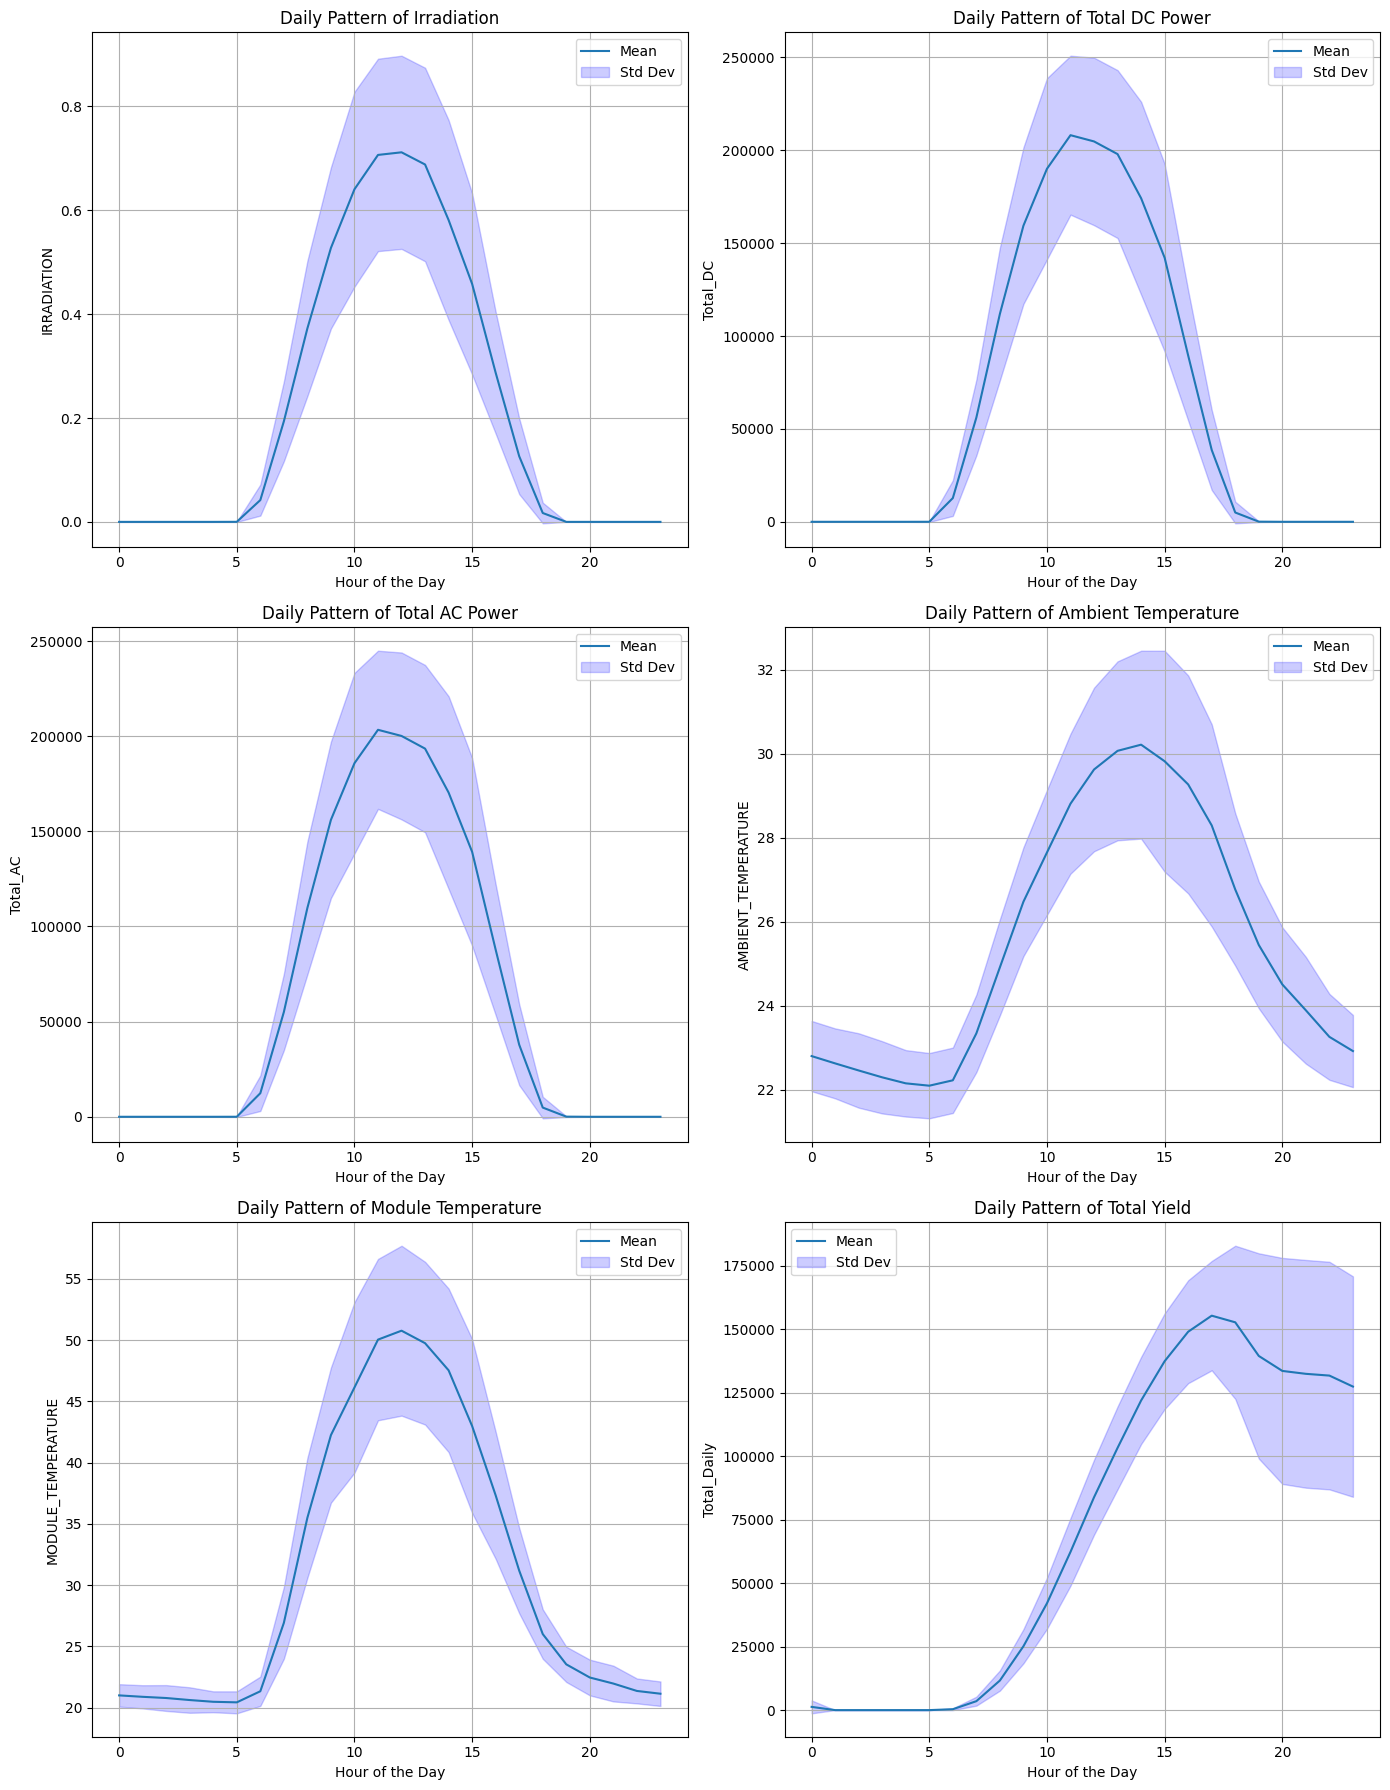

In [164]:
# Additional plots
# Daily pattern with standard deviation
def plot_daily_pattern(df, column, ax, title):
    df_copy = df.copy()
    df_copy['Hour'] = df_copy['DATE_TIME'].dt.hour
    daily_pattern_mean = df_copy.groupby('Hour')[column].mean()
    daily_pattern_std = df_copy.groupby('Hour')[column].std()
    
    ax.plot(daily_pattern_mean.index, daily_pattern_mean.values, label='Mean')
    ax.fill_between(daily_pattern_mean.index, 
                    daily_pattern_mean.values - daily_pattern_std.values, 
                    daily_pattern_mean.values + daily_pattern_std.values, 
                    color='b', alpha=0.2, label='Std Dev')
    ax.set_title(title)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel(column)
    ax.grid()
    ax.legend()

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 18))

# Plot daily patterns for Total_DC, Total_AC, and Total_Yield
plot_daily_pattern(df_summed, 'IRRADIATION', axs[0, 0], 'Daily Pattern of Irradiation')
plot_daily_pattern(df_summed, 'Total_DC', axs[0, 1], 'Daily Pattern of Total DC Power')
plot_daily_pattern(df_summed, 'Total_AC', axs[1, 0], 'Daily Pattern of Total AC Power')
plot_daily_pattern(df_summed, 'AMBIENT_TEMPERATURE', axs[1, 1], 'Daily Pattern of Ambient Temperature')
plot_daily_pattern(df_summed, 'MODULE_TEMPERATURE', axs[2, 0], 'Daily Pattern of Module Temperature')
plot_daily_pattern(df_summed, 'Total_Daily', axs[2, 1], 'Daily Pattern of Total Yield')

plt.tight_layout()
plt.show()

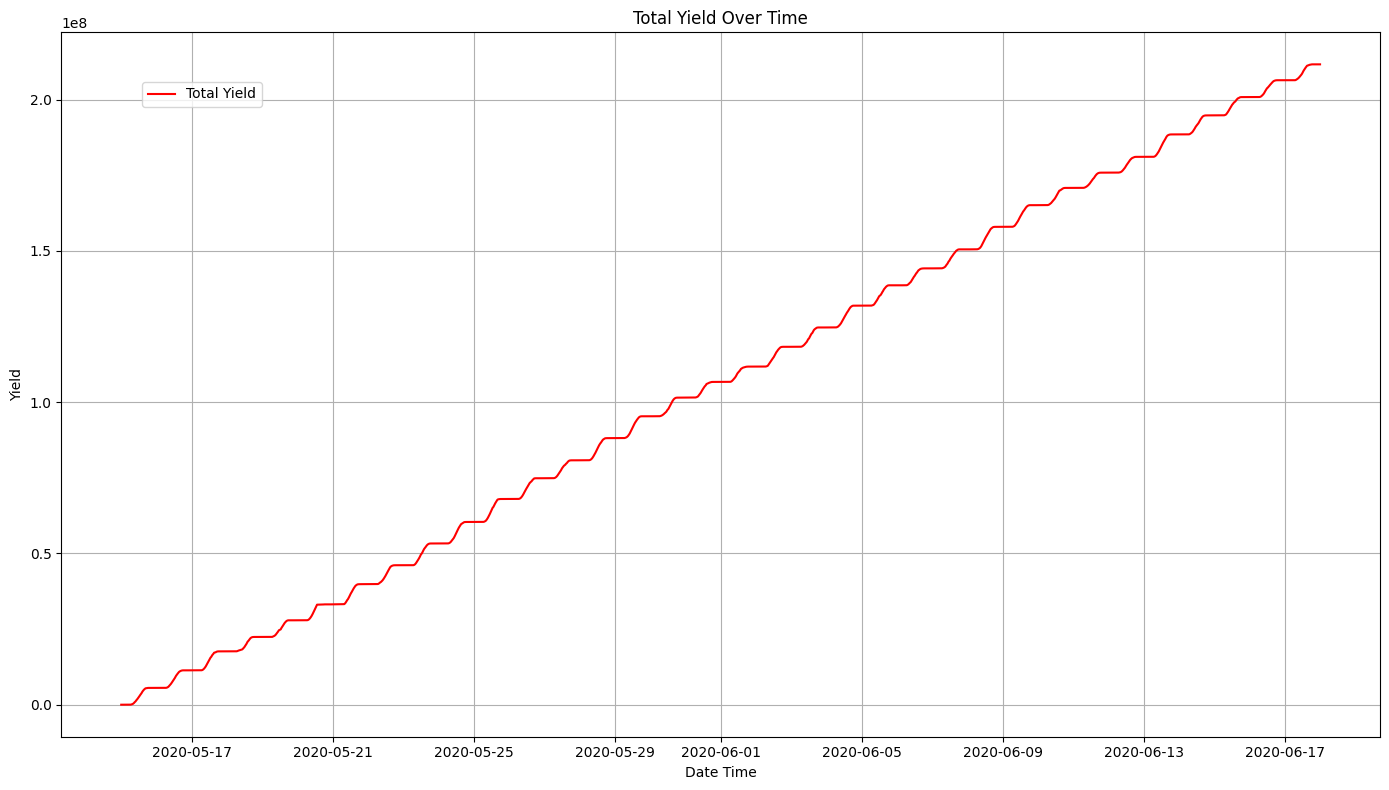

In [166]:

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(df_summed['DATE_TIME'], df_summed['Total_Yield'], label='Total Yield', color='r')
ax1.set_xlabel('Date Time')
ax1.set_ylabel('Yield')
ax1.tick_params(axis='y')
ax1.grid()

# Add title and legends
plt.title('Total Yield Over Time')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()